In [22]:
import os
import torchvision
from torchvision import models,transforms,datasets
import torch.nn as nn
import torch
import time
import matplotlib.pyplot as plt

## Preprocess data

In [2]:
data_dir = '/home/foodlovers/FoodVisor/data/images'

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
def shuffle_valtrain(x):
    if x == 'train':
        return True
    else :
        return False
    

In [4]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'test']}

In [5]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_sizes

{'train': 67988, 'test': 22716}

In [6]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=32,
                                               shuffle=shuffle_valtrain(x), num_workers=6)
                for x in ['train', 'test']}

## Create model

In [7]:
model_resnet = models.resnet18(pretrained=True)

In [11]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [16]:
for data in dset_loaders['train']:
    inputs_try,labels_try = data
    break

In [17]:
inputs_try.shape

torch.Size([32, 3, 224, 224])

In [18]:
outputs_try = model_resnet(inputs_try)
outputs_try.shape

torch.Size([32, 1000])

In [8]:
model_resnet.fc = nn.Linear(512, 101)

In [9]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

Using gpu: True 


In [10]:
if use_gpu :
    model_resnet = model_resnet.cuda()

## Training

### Train function

In [34]:
path_save_1 = '/home/foodlovers/FoodVisor/trained_models/Resnet18/model_best_0.pt'
path_save_2 = '/home/foodlovers/FoodVisor/trained_models/Resnet18/model_current_0.pt'

def train_model(model, criterion,
                 train_loaders = None,
                 test_loaders = None,
                  optimizer = None,
                 epochs = 1,train = True, validate = False,
                shuffle = True) :
    
    if train == True :
        loss_history = []
        acc_history = []
        val_loss_history = []
        val_acc_history = []
        
    for epoch in range(epochs) :
        if train == True :
            #=========================TRAINING=================================#
            start_time_epoch = time.time()
            
            model.train()
    
            print("Epoch:", epoch+1,"/",epochs,"===============================================")
        
            running_loss = 0.0
            running_corrects = 0.0


            for i, data in enumerate(train_loaders, 0):
                start_time = time.time()

                # get the inputs
                inputs, classes = data

                if use_gpu:
                    inputs , classes = inputs.cuda(), classes.cuda()

                # calulate outputs and losses
                outputs = model(inputs)
                loss = criterion(outputs,classes)         

                # autograd
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # statistics
                batch_loss = loss.data.item()
                _,preds = torch.max(outputs.data,1)
                batch_corrects = torch.sum(preds == classes.data)
                running_loss += batch_loss
                running_corrects += batch_corrects

                print('Batch {:d}/{:d} - Loss: {:.4f} Acc: {:.4f} - Time : {:.2f}s'.format(i+1,len(dset_loaders['train']),
                             batch_loss/len(classes), float(batch_corrects)/len(classes), time.time() - start_time), end="\r")

            epoch_loss = running_loss / dset_sizes['train']
            epoch_acc = running_corrects.data.item() / dset_sizes['train']
            
            loss_history.append(epoch_loss)
            acc_history.append(epoch_acc)
            
            print('Epoch {:d} completed in {:.2f} seconds ! Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch+1, time.time() - start_time_epoch, epoch_loss, epoch_acc))
            
            torch.save(model.state_dict(), path_save_2)
            
        if validate == True :
            #=========================VALIDATING=================================#
            
            model.eval()
            
            val_loss = 0.0
            val_corrects = 0.0
            
            total = 0

            for i, data in enumerate(test_loaders, 0):
                start_time = time.time()
                
                # get the inputs
                inputs, classes = data

                if use_gpu:
                    inputs , classes = inputs.cuda(), classes.cuda()

                outputs = model(inputs)

                loss = criterion(outputs,classes)        

                _,preds = torch.max(outputs.data,1)

                # statistics

                val_loss += loss.data.item()
                val_corrects += torch.sum(preds == classes.data)
                total += classes.size(0)
                
                print('Validating batch {:d}/{:d} - {:.2f}s ...'.format(i+1,len(dset_loaders['test'])
                                                                , time.time() - start_time), end="\r")

            val_epoch_loss = val_loss / dset_sizes['test']
            val_epoch_acc = val_corrects.data.item() / dset_sizes['test']

            print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(
                             val_epoch_loss,val_epoch_acc))
            
            if train == False :
                return
            else :
                if len(val_acc_history) == 0 or val_epoch_acc >= max(val_acc_history) :
                    torch.save(model.state_dict(), path_save_1)
                
                val_loss_history.append(val_epoch_loss)
                val_acc_history.append(val_epoch_acc)
    
    if train == False :
        return 'On fait rien!'
    elif validate == False :
        return loss_history, acc_history
    else :
        return loss_history, acc_history,val_loss_history,val_acc_history

### Loss & Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_resnet = torch.optim.SGD(model_resnet.parameters(),lr = lr, momentum = 0.9)

### Run Train

In [15]:
history = train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 5,train = True, validate = True,
                shuffle = True)

Epoch: 0 / 5 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 0 completed in 577.32 seconds ! Loss: 0.0805 Acc: 0.3949
Val Loss: 0.0705 Val Acc: 0.4742 ...
Epoch: 1 / 5 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 1 completed in 580.40 seconds ! Loss: 0.0733 Acc: 0.4443
Val Loss: 0.0665 Val Acc: 0.5160 ...
Epoch: 2 / 5 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 2 completed in 578.72 seconds ! Loss: 0.0687 Acc: 0.4770
Val Loss: 0.0616 Val Acc: 0.5396 ...
Epoch: 3 / 5 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 3 completed in 580.38 seconds ! Loss: 0.0653 Acc: 0.4990
Val Loss: 0.0619 Val Acc: 0.5329 ...
Epoch: 4 / 5 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 4 completed in 578.58 seconds ! Loss: 0.0623 Acc: 0.5207
Val Loss: 0.0589 Val Acc: 0.5611 ...


In [13]:
model_resnet.load_state_dict(torch.load('/home/foodlovers/FoodVisor/trained_models/Resnet18/model_current.pt'))

In [16]:
train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 10,train = False, validate = True,
                shuffle = True)

Val Loss: 0.0589 Val Acc: 0.5611 ...


In [17]:
history_2 = train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 5,train = True, validate = True,
                shuffle = True)

Epoch: 0 / 5 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 0 completed in 579.23 seconds ! Loss: 0.0601 Acc: 0.5378
Val Loss: 0.0567 Val Acc: 0.5794 ...
Epoch: 1 / 5 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 1 completed in 578.62 seconds ! Loss: 0.0581 Acc: 0.5509
Val Loss: 0.0562 Val Acc: 0.5856 ...
Epoch: 2 / 5 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 2 completed in 580.43 seconds ! Loss: 0.0564 Acc: 0.5606
Val Loss: 0.0568 Val Acc: 0.5883 ...
Epoch: 3 / 5 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 3 completed in 578.71 seconds ! Loss: 0.0545 Acc: 0.5707
Val Loss: 0.0550 Val Acc: 0.5990 ...
Epoch: 4 / 5 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 4 completed in 580.23 seconds ! Loss: 0.0531 Acc: 0.5823
Val Loss: 0.0541 Val Acc: 0.6062 ...


In [24]:
for i in range(4):
    history[i].extend(history_2[i])

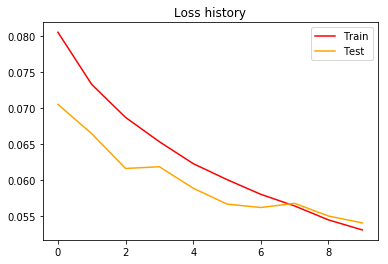

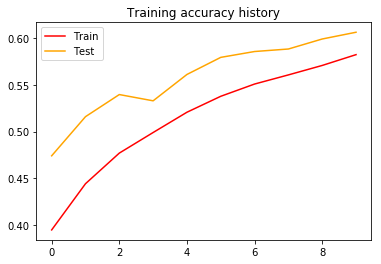

In [25]:
plt.figure(1)
plt.plot(history[0],color='red',label='Train')
plt.plot(history[2],color='orange',label='Test')
plt.legend()
plt.title("Loss history")

plt.figure(2)
plt.plot(history[1],color='red',label='Train')
plt.plot(history[3],color='orange',label='Test')
plt.legend()
plt.title("Training accuracy history")

plt.show()

In [18]:
lr = 0.001
optimizer_resnet = torch.optim.SGD(model_resnet.parameters(),lr = lr, momentum = 0.9)

In [26]:
history_3 = train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 10,train = True, validate = True,
                shuffle = True)

Epoch: 0 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 0 completed in 577.77 seconds ! Loss: 0.0441 Acc: 0.6500
Val Loss: 0.0481 Val Acc: 0.6539 ...
Epoch: 1 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 1 completed in 582.52 seconds ! Loss: 0.0413 Acc: 0.6718
Val Loss: 0.0476 Val Acc: 0.6591 ...
Epoch: 2 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 2 completed in 592.85 seconds ! Loss: 0.0400 Acc: 0.6812
Val Loss: 0.0475 Val Acc: 0.6622 ...
Epoch: 3 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 3 completed in 592.46 seconds ! Loss: 0.0392 Acc: 0.6860
Val Loss: 0.0469 Val Acc: 0.6624 ...
Epoch: 4 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 4 completed in 594.01 seconds ! Loss: 0.0386 Acc: 0.6905
Val Loss: 0.0472 Val Acc: 0.6661 ...
Epoch: 5 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 5 completed in 593.76 seconds ! Loss: 0.0379 Acc: 0.6955


RuntimeError: DataLoader worker (pid 8809) is killed by signal: Bus error. 

In [27]:
train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 10,train = False, validate = True,
                shuffle = True)

Val Loss: 0.0476 Val Acc: 0.6667 ...


In [28]:
history_3 = [[0.0441,0.0413 ,0.0400,0.0392,0.0386],
            [0.6500,0.6718 ,0.6812,0.6860,0.6905],
            [0.0481,0.0476 ,0.0475,0.0469,0.0472],
            [0.6539,0.6591 ,0.6622,0.6624,0.6661]]

for i in range(4):
    history[i].extend(history_3[i])

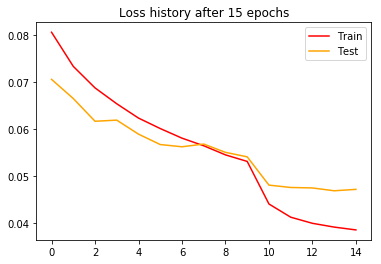

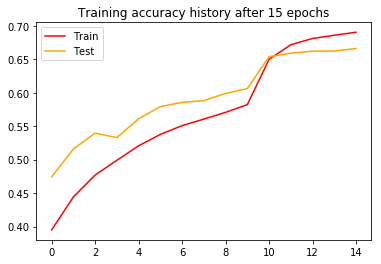

In [29]:
plt.figure(1)
plt.plot(history[0],color='red',label='Train')
plt.plot(history[2],color='orange',label='Test')
plt.legend()
plt.title("Loss history after 15 epochs")

plt.figure(2)
plt.plot(history[1],color='red',label='Train')
plt.plot(history[3],color='orange',label='Test')
plt.legend()
plt.title("Training accuracy history after 15 epochs")

plt.show()

## Without data augmentation + resize

In [31]:
prep1 = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

In [32]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep1)
         for x in ['train', 'test']}

dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=32,
                                               shuffle=shuffle_valtrain(x), num_workers=6)
                for x in ['train', 'test']}

In [33]:
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(512, 101)
if use_gpu :
    model_resnet = model_resnet.cuda()

In [35]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_resnet = torch.optim.SGD(model_resnet.parameters(),lr = lr, momentum = 0.9)

In [36]:
history_4 = train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 10,train = True, validate = True,
                shuffle = True)

Epoch: 1 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 1 completed in 577.64 seconds ! Loss: 0.0977 Acc: 0.2851
Val Loss: 0.0864 Val Acc: 0.3547 ...
Epoch: 2 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 2 completed in 578.50 seconds ! Loss: 0.0753 Acc: 0.4244
Val Loss: 0.0832 Val Acc: 0.3975 ...
Epoch: 3 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 3 completed in 580.13 seconds ! Loss: 0.0638 Acc: 0.5005
Val Loss: 0.0767 Val Acc: 0.4368 ...
Epoch: 4 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 4 completed in 578.67 seconds ! Loss: 0.0542 Acc: 0.5666
Val Loss: 0.0798 Val Acc: 0.4382 ...
Epoch: 5 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 5 completed in 580.33 seconds ! Loss: 0.0451 Acc: 0.6303
Val Loss: 0.0790 Val Acc: 0.4487 ...
Epoch: 6 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 6 completed in 580.58 seconds ! Loss: 0.0363 Acc: 0.6935
Val Loss: 0.0860 Val Acc: 0.4384 ...
Epoch: 7 / 10 ===============================================


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
Traceback (most recent call last):
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
Traceback (most recent call last):
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/home/foodlovers/

OSError: [Errno 28] No space left on device: '/tmp/pymp-dtfbfojy'
OSError: [Errno 28] No space left on device: '/tmp/pymp-rvkhlt0z'
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/util.py", line 114, in get_temp_dir
    tempdir = tempfile.mkdtemp(prefix='pymp-')
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/connection.py", line 76, in arbitrary_address
    return tempfile.mktemp(prefix='listener-', dir=util.get_temp_dir())
  File "/home/foodlovers/miniconda3/lib/python3.7/tempfile.py", line 366, in mkdtemp
    _os.mkdir(file, 0o700)
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/util.py", line 114, in get_temp_dir
    tempdir = tempfile.mkdtemp(prefix='pymp-')
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/reduction.py", line 194, in DupFd
    return resource_sharer.DupFd(fd)
  File "/home/foodlovers/miniconda3/lib/python3.7/tempfile.py", line 366, in mkdtemp
    _os.mkdir(file, 0o700)
OSError: [Errno 28] No sp

  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 77, in register
    self._start()
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 130, in _start
    self._listener = Listener(authkey=process.current_process().authkey)
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/connection.py", line 432, in __init__
    address = address or arbitrary_address(family)
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/connection.py", line 76, in arbitrary_address
    return tempfile.mktemp(prefix='listener-', dir=util.get_temp_dir())
  File "/home/foodlovers/miniconda3/lib/python3.7/multiprocessing/util.py", line 114, in get_temp_dir
    tempdir = tempfile.mkdtemp(prefix='pymp-')
  File "/home/foodlovers/miniconda3/lib/python3.7/tempfile.py", line 366, in mkdtemp
    _os.mkdir(file, 0o700)
OSError: [Errno 28] No space left on device: '/tmp/pymp-tesj77jf'
Traceback (most recent call 

KeyboardInterrupt: 

In [37]:
history_4 = train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 4,train = True, validate = True,
                shuffle = True)

Epoch: 1 / 4 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 1 completed in 578.44 seconds ! Loss: 0.0281 Acc: 0.7558
Val Loss: 0.0913 Val Acc: 0.4450 ...
Epoch: 2 / 4 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 2 completed in 578.82 seconds ! Loss: 0.0211 Acc: 0.8133
Val Loss: 0.1028 Val Acc: 0.4356 ...
Epoch: 3 / 4 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 3 completed in 581.13 seconds ! Loss: 0.0155 Acc: 0.8615
Val Loss: 0.1033 Val Acc: 0.4411 ...
Epoch: 4 / 4 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 4 completed in 579.24 seconds ! Loss: 0.0115 Acc: 0.8976
Val Loss: 0.1049 Val Acc: 0.4524 ...


In [39]:
history_5 = [[0.0977,0.0753 ,0.0638,0.0542,0.0451,0.0363],
            [0.2851,0.4244 ,0.5005,0.5666,0.6303,0.6935],
            [0.0864 ,0.0832 ,0.0767,0.0798,0.0790,0.0860],
            [0.3547,0.3975 , 0.4368,0.4382,0.4487,0.4384]]

for i in range(4):
    history_5[i].extend(history_4[i])

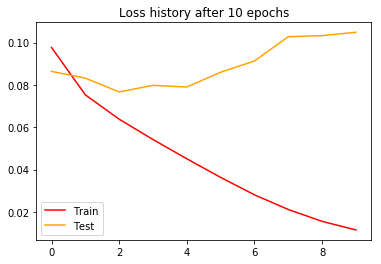

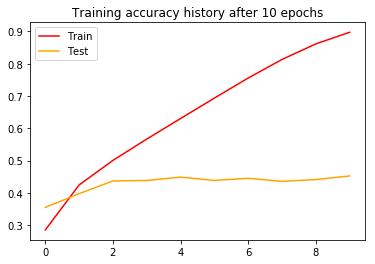

In [41]:
plt.figure(1)
plt.plot(history_5[0],color='red',label='Train')
plt.plot(history_5[2],color='orange',label='Test')
plt.legend()
plt.title("Loss history after 10 epochs")

plt.figure(2)
plt.plot(history_5[1],color='red',label='Train')
plt.plot(history_5[3],color='orange',label='Test')
plt.legend()
plt.title("Training accuracy history after 10 epochs")

plt.show()